In [1]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def loaddata():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = (x_train[(y_train == 5) | (y_train == 7),]- 127.5) / 127.5
#     x_train = np.expand_dims(x_train, axis=3)
    y_train = y_train[(y_train == 5) | (y_train == 7)]
    y_train = np.where(y_train == 5, 0, 1).reshape((-1,1))

    x_test = (x_test[(y_test == 5) | (y_test == 7),]- 127.5) / 127.5
#     x_test = np.expand_dims(x_test, axis=3)
    y_test = y_test[(y_test == 5) | (y_test == 7)]
    y_test = np.where(y_test == 5, 0, 1).reshape((-1,1))

    np.random.seed(0)
    rand_idx = np.random.choice(np.arange(x_train.shape[0]), size = 10, replace = False)
    inverse_idx = [i for i in np.arange(x_train.shape[0]) if i not in rand_idx]
    x_train_labelled = x_train[rand_idx]
    y_train_labelled = y_train[rand_idx]
    x_train_unlabelled = x_train[inverse_idx]
    y_train_unlabelled = y_train[inverse_idx]

    return x_train_labelled, y_train_labelled, x_train_unlabelled, y_train_unlabelled, x_test, y_test

In [3]:
x_train_labelled, y_train_labelled, x_train_unlabelled, y_train_unlabelled, x_test, y_test = loaddata()

x_test = np.squeeze(x_test)
x_test = x_test.reshape((x_test.shape[0],-1))
y_test = y_test.ravel()

In [4]:
def trainsvc(xtrain, ytrain):
    x = np.squeeze(xtrain)
    xt = x.reshape((x.shape[0],-1))
    svc = SVC(kernel='linear', probability = True, gamma=0.001).fit(xt, ytrain.ravel())
    return svc

In [5]:
def getidxofnearesttoplane(svc, unlabelleddata):
    unlabelleddata = np.squeeze(unlabelleddata)
    unlabelleddata = unlabelleddata.reshape((unlabelleddata.shape[0],-1))
    
    w = svc.coef_
    b = svc.intercept_
    w_norm = np.linalg.norm(w)
    dist_list = []

    for r in range(unlabelleddata.shape[0]):
        d = np.abs(np.dot(w,unlabelleddata[r]) + b)/w_norm
        dist_list.append(d)
    
    idx_nearest_to_hyperplane = np.argmin(dist_list)
    
    return idx_nearest_to_hyperplane

In [6]:
def loadoracle(oraclepath):
    oracle = load_model(oraclepath)
    oracle.trainable = False
    return oracle

In [7]:
oracle = loadoracle('./oracles/mnist57.h5')

In [176]:
accuracy = []
for i in range(5):
    # update SVC
    svc = trainsvc(x_train_labelled, y_train_labelled)
    
    # get test set accuracy
    test_preds = svc.predict(x_test)
    acc = accuracy_score(y_test, test_preds)
    accuracy.append(acc)
    
    cnt = 0
    while cnt < 10:
        # get index of most uncertain sample
        unsure_idx = getidxofnearesttoplane(svc, x_train_unlabelled)
        # use oracle to predict uncertain sample
        unsure_img = x_train_unlabelled[unsure_idx]
        unsure_img = np.expand_dims(unsure_img, axis = 0)
        unsure_img = np.expand_dims(unsure_img, axis = 3)
        unsure_img_3c = np.repeat(unsure_img, 3, axis = 3)
        unsure_img_3c_32 = (tf.image.resize(unsure_img_3c, [32,32]) + 1)/2
        oracle_label = np.squeeze(oracle.predict(unsure_img_3c_32))
        # get label of uncertain sample
        new_label = np.reshape(np.round(oracle_label).astype('int'), (1,1))
        new_labelled_img = np.expand_dims(x_train_unlabelled[unsure_idx], axis = 0)
        # add to labelled set
        y_train_labelled = np.concatenate((y_train_labelled, new_label), axis = 0)
        x_train_labelled = np.concatenate((x_train_labelled, new_labelled_img), axis = 0)
        # delete from unlabelled set
        x_train_unlabelled = np.delete(x_train_unlabelled, unsure_idx, axis = 0)
        y_train_unlabelled = np.delete(y_train_unlabelled, unsure_idx, axis = 0)
        cnt += 1

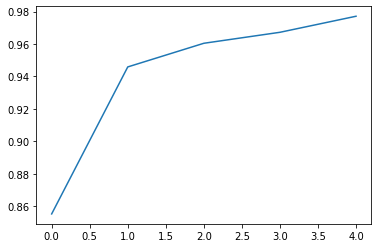

In [177]:
plt.plot(accuracy)

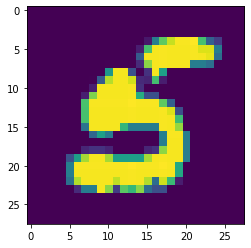

In [80]:
a = (x_train_unlabelled[np.argmax(np.abs((unlabelled_proba-0.5)))]*127.5) + 127.5
a = a.astype('uint8')
plt.imshow(a)